# Running Ensemble Inference in Earth-2 MIP

The following notebook demostrates how to use Earth-2 MIP's config schema and builtin inference workflows to perform ensemmble inference of the FourCastNetv2 small (FCNv2-sm) weather model and of the Pangu weather model with an intial state pulled from the Climate Data Store (CDS) and perturbed with random noise. The ensemble output will then be loaded into an Xarray Dataset and some sample data analysis is provided.

In summary this notebook will cover the following topics:

- Configuring and setting up FCNv2 and Pangu model registries
- An ensemble configuration file
- Running ensemble inference in Earth-2 MIP to produce an xarray DataSet
- Post processing results

## Set Up

Starting off with imports, hopefully you have already installed Earth-2 MIP from this repository. There are a few additional packages needed. Lets install these first.

In [1]:
%%capture
!pip install cartopy

In [2]:
# For running inference we dont need much
import os, json, logging
import xarray
from torch import distributed
from modulus.distributed.manager import DistributedManager

Prior to importing Earth-2 MIP, its critical we set up a few enviroment variables which will help Earth-2 MIP get configured correctly under the hood. There are a number of different global configuration options, the ones will will set here are:

- `WORLD_SIZE`: Tells Earth-2 MIP (which uses Modulus under the hood) the number of GPUs present
- `MODEL_REGISTRY`: This variable tells Earth-2 MIP where look for a model registery

*Key Concept*: A model registry is a folder that Earth-2 MIP will explore to find model checkpoints to load. A folder containing the required fileds is referred to as a "model package". Model packages typically consist of a few files including:
- `weights.tar`: the Pytorch model checkpoint to load
- `metadata.json`: a JSON file that contains meta info regarding various details for using the model
- `config.json`: constains parameters needed to instantiate the model object in python
- `global_means.npy`: A numpy array containing the mean values used for normalization of data in the model
- `global_std.npy`: A numpy array containing the standard deviation values used for normalization of data in the model

In [3]:
# Set number of GPUs to use to 1
os.environ['WORLD_SIZE'] = '1'
# Set model registry as a local folder
model_registry = os.path.join(os.path.dirname(os.path.realpath(os. getcwd())), "models")
os.makedirs(model_registry, exist_ok=True)
os.environ['MODEL_REGISTRY'] = model_registry
logging.basicConfig(level=logging.INFO)

# With the enviroment variables set now we import Earth-2 MIP
from earth2mip.inference_ensemble import get_model, run_inference, get_initializer
from earth2mip.schema import EnsembleRun

The cell above created a model registry folder for us, but if this is your first notebook its likely empty. Lets fix that. As previously metioned we will be using the FCNv2-sm weather model with the checkpoint provided on the Nvidia Modulus model registry and the Pangu weather model with the checkpoint provided by ECMWF. The model is shipped via a zip folder containing the required checkpoint files discussed above.

In [4]:
import subprocess
if not os.path.isdir(os.path.join(model_registry, 'fcnv2_sm')):
    print("Downloading model checkpoint, this may take a bit")
    subprocess.run(['wget', '-nc', '-P', f'{model_registry}', 'https://api.ngc.nvidia.com/v2/models/nvidia/modulus/modulus_fcnv2_sm/versions/v0.2/files/fcnv2_sm.zip'], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    subprocess.run(['unzip', '-u', f'{model_registry}/fcnv2_sm.zip', '-d', f'{model_registry}'])
    subprocess.run(['rm', f'{model_registry}/fcnv2_sm.zip'])

if not os.path.isdir(os.path.join(model_registry, 'pangu')):
    pangu_registry = os.path.join(model_registry, "pangu")
    os.makedirs(pangu_registry, exist_ok=True)
    # Wget onnx files
    print("Downloading model checkpoint, this may take a bit")
    subprocess.run(['wget', '-nc', '-P', f'{pangu_registry}', 'https://get.ecmwf.int/repository/test-data/ai-models/pangu-weather/pangu_weather_24.onnx'], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    subprocess.run(['wget', '-nc', '-P', f'{pangu_registry}', 'https://get.ecmwf.int/repository/test-data/ai-models/pangu-weather/pangu_weather_6.onnx'], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

    with open(os.path.join(pangu_registry, 'metadata.json'), 'w') as outfile:
        json.dump({"entrypoint": {"name": "earth2mip.networks.pangu:load"}}, outfile, indent=2)

The final setup step is to set up your CDS API key so we can access ERA5 data to act as an initial state. Earth-2 MIP supports a number of different initial state data sources that are supported including HDF5, CDS, GFS, etc. The CDS initial state provides a convenient way to access a limited amount of historical weather data. Its recommended for accessing an initial state, but larger data requirements should use locally stored weather datasets.

Enter your CDS API uid and key below (found under your profile page). If you don't a CDS API key, find out more here.
- [https://cds.climate.copernicus.eu/cdsapp#!/home](https://cds.climate.copernicus.eu/cdsapp#!/home)
- [https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to)

In [5]:
# Run this cell and input your credentials in the notebook
cds_api = os.path.join(os.path.expanduser("~"), '.cdsapirc')
if not os.path.exists(cds_api):
    uid = input("Enter in CDS UID (e.g. 654321)")
    key = input("Enter your CDS API key (e.g. 12345678-1234-1234-1234-123456123456)")
    # Write to config file for CDS library
    with open(cds_api, 'w') as f:
        f.write('url: https://cds.climate.copernicus.eu/api/v2\n')
        f.write(f'key: {uid}:{key}\n')

## Running Inference

To run inference we will use the `earth2mip/ensemble_inference.py` part of Earth-2 MIP. When this Python file, we provide either a config JSON file or a JSON serialized string for it to parse. This config contains the information regarding how the model should run inference. The schema of this can be found in `earth2mip/schema/EnsembleRun`.

Since we are working in a notebook, lets create this config Pythonically. There are quite a few parameters that can be used, but lets focus in on a few key ones:

- `ensemble_members`: Number ensemble members in the forecast
- `noise_amplitude`: The amplitude of the noise pertibation method (we find that a good value to start with is `0.05`, feel free to experiment)
- `simulation_length`: Number of (6h) time-steps to predict
- `weather_event`: This defines the weather event as a combination of an initial time and a domain. 
    * The domain property defines the IO, ,by telling Earth-2 MIP for what regions (if `window`) or points (if `multipoint`) data should be stored. It also defines the `channels` and the diagnostic.  In this example the global field is recorded for the `t2m` and `u10m` channels. You can further also explore the `diagnostics` options in Diagnostics class in earth2mip/Diagnostics.py.
- `output_path`: The output location of the ensemble prediction netCDF file
- `weather_model`: The model ID to run. This MUST match the name of the model registry folder with your checkpoint files. So for this example its either `fcnv2_sm` or `pangu`. Also, pay attention that the diagnostics channels are actually included in the weather model of your choice. You can find out channel names by calling `model.channel_names` after calling `get_model`, or just looking up the files under `earth2mip/networks/{weather_model}.py`

Note: While in later notebooks we will demonstrate more Pythonic methods to interact with Earth-2 MIP's APIs, the built in inference workflows provide a high-degree of control with little to no programming.

The following config is base config defining initial condition, prediction length and output domains and variables. The weather model will be defined before running the model. Note that here we chose two output domains: the first domain is a lat/lon box over central and eastern Europe, the second domain consists of a list of lat/lon points.

In [6]:
base_config = {
    "ensemble_members": 4,
    "noise_amplitude": 0.01,
    "simulation_length": 80,
    "weather_event": {
        "properties": {
            "name": "Globe",
            "start_time": "2022-07-01 00:00:00",
            "initial_condition_source": "cds"
        },
        "domains": [
            {
                "name": "eu",
                "type": "Window",
                "lat_min": 36,
                "lat_max": 71,
                "lon_min": 0,
                "lon_max": 35,
                "diagnostics": [
                    {
                        "type": "raw",
                        "channels": [
                            "t2m",
                            "u10m"
                        ]
                    }
                ]
            },
            {
                "name": "eu_cities",
                "type": "MultiPoint",
                "lat": [48.75, 43.50],
                "lon": [2.50, 5.25],
                "diagnostics": [
                    {
                        "type": "raw",
                        "channels": [
                            "t2m",
                            "u10m"
                        ]
                    }
                ]
            }
        ]
    },
    "output_frequency": 1,
    "seed": 12345,
    "use_cuda_graphs": False,
    "ensemble_batch_size": 1,
    "autocast_fp16": False,
    "perturbation_strategy": "correlated",
    "noise_reddening": 2.0
}

Now we run the `main()` function in `earth2mip.inference_ensemble` providing our config object which will run inference with the following steps:

1. Instantiate and load the FCNv2 small weather model onto the device
2. Download the initial state data needed from CDS using your saved API key
3. Perturb the initial state based on the parameters in the config and run a forecast predicton
4. Save output Xarray dataset to NetCDF file located in `../outputs/01_ensemble_notebook`

(the process may take a while!)

In [7]:
weather_model = 'pangu' # 'fcnv2_sm' or 'pangu' for this example

model_config = {"weather_model": weather_model,
                "output_path": f"../outputs/04_nov_dem/{weather_model}",}
config: EnsembleRun = EnsembleRun.parse_obj(base_config | model_config)

Tell the programm which hardware to use by initialising the distributed manager. then load the model and inital conditions, then perform inference (This might take a couple of minutes, depending on ensemble size. Impact of lead time is not that big.)

In [8]:
# Set up parallel
DistributedManager.initialize()
device = DistributedManager().device
group = distributed.group.WORLD

# load model to device, get initial conditions and run inference
print(f"Loading model onto device {device}")
model = get_model(config.weather_model, device=device)
print("Constructing initializer data source")
perturb = get_initializer(model, config, )
print("Running inference")
run_inference(model, config, perturb, group)

Loading model onto device cuda:0


INFO:earth2mip.initial_conditions.cds:Found data in cache. Using /root/.cache/earth2mip/cds/cf241be9a7e01c65140c4a3f94e76cf077def686d3c09dc8645fbd587deafd99/reanalysis-era5-pressure-levels.grib.
INFO:earth2mip.initial_conditions.cds:Found data in cache. Using /root/.cache/earth2mip/cds/e13bc691d9513ab089eb49d4f6029423d7f6e47dbf78b6f6cf6a4955c61e2254/reanalysis-era5-single-levels.grib.


Constructing initializer data source
Running inference


INFO:inference:ensemble members 1-1/4
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:779: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
INFO:inference:ensemble members 2-2/4
INFO:inference:ensemble members 3-3/4
INFO:inference:ensemble members 4-4/4
INFO:inference:Ensemble forecast finished, saved to: ../outputs/04_nov_dem/pangu/ensemble_out_0.nc


When the inference is complete we can examine the output in `../ouputs/04_nov_dem/{weather_model}/ensemble_out_0.nc`. 

Note: if the inference is distributed across N GPUs there will be `ensemble_out_0.nc`,`ensemble_out_1.nc`, ... `ensemble_out_N-1.nc` output files. 
In this case a function like this could concat the files to a single xarray DataArray:

```python
def _open(f, domain, time, chunks={"time": 1}):
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=lead_time)


def open_ensemble(path, domain, time):
    path = pathlib.Path(path)
    ensemble_files = list(path.glob("ensemble_out_*.nc"))
    return xarray.concat(
        [_open(f, group, time) for f in ensemble_files], dim="ensemble"
    )
```

(TODO: Move this into a parallel inference notebook!)

But with our single NetCDF file we can load it into a [Xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) with just a few lines of code. All you need to do is specify the model and which of the domains defined in your config you want to look at.

In [9]:
domain_idx = 0
weather_model = 'pangu'

def open_ensemble(f, domain, chunks={"time": 1}):
    time = xarray.open_dataset(f).time
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=time)

dat_file = f"../outputs/04_nov_dem/{weather_model}/ensemble_out_0.nc"
root = xarray.open_dataset(dat_file, decode_times=False)
config = json.loads(root.attrs['config'])
domain = config['weather_event']["domains"][domain_idx]
ds = open_ensemble(dat_file, domain['name'])
ds

<xarray.Dataset>
Dimensions:  (lat: 141, lon: 141, ensemble: 4, time: 81)
Coordinates:
  * lat      (lat) float32 71.0 70.75 70.5 70.25 70.0 ... 36.75 36.5 36.25 36.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 34.0 34.25 34.5 34.75 35.0
  * time     (time) datetime64[ns] 2022-07-01 2022-07-01T06:00:00 ... 2022-07-21
Dimensions without coordinates: ensemble
Data variables:
    imin     int64 ...
    imax     int64 ...
    jmin     int64 ...
    jmax     int64 ...
    t2m      (ensemble, time, lat, lon) float64 dask.array<chunksize=(4, 1, 141, 141), meta=np.ndarray>
    u10m     (ensemble, time, lat, lon) float64 dask.array<chunksize=(4, 1, 141, 141), meta=np.ndarray>
Attributes:
    model:          pangu
    config:         {"weather_model": "pangu", "simulation_length": 80, "pert...
    weather_event:  {"properties": {"name": "Globe", "start_time": "2022-07-0...
    date_created:   2023-11-16T10:55:16.340168
    history:        /usr/local/lib/python3.10/dist-packages/ipykernel_launche...
    institution:    NVIDIA
    Conventions:    CF-1.10

## Post Processing

With inference complete, now the fun part: post processing and analysis!
You can manipulate the data to your hearts content now that its in an Xarray Dataset.
Here we will demonstrate some common plotting / analysis workflows one may be interested.
Lets start off with importing all our post processing packages.

In [10]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from io import StringIO
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime, timedelta

countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none',
    edgecolor='black'
)

Up first, we can plot a time series of the value of a variable (or statistics of that variable) at a given location (lat/lon coord). We can either select one of the points of the MultiPoints domain, or choose a point included in the window domain. Make sure to load the associated domain in the cell which opens the data set.

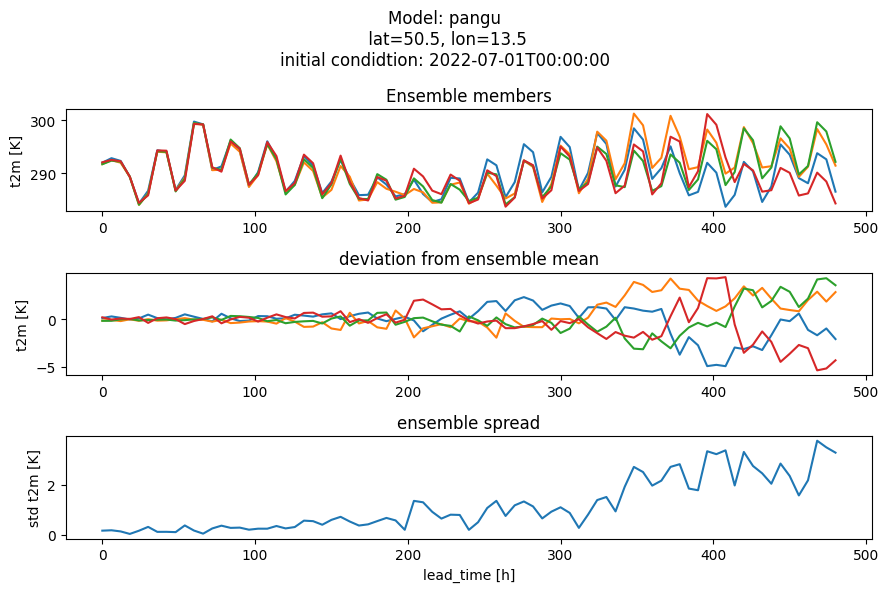

In [11]:
# plot time series of points
if domain['type'] == 'MultiPoint':
    selection = 0 # id of point
    loc = ds.sel(npoints=selection)
    _lat, _lon = float(loc.lat_point), float(loc.lon_point)
elif domain['type'] == 'Window':
    selection = (50.5, 13.5) # lat/lon coords of point of interest
    loc = ds.sel(lat=selection[0], lon=selection[1])
    _lat, _lon = selection
else:
    raise ValueError(f'plotting time series not implemented for domain type {domain["type"]}')

lead_time = np.array((pd.to_datetime(ds.time) - pd.to_datetime(ds.time)[0]).total_seconds()/3600)
fig = plt.figure(figsize=(9, 6))
fig.suptitle(f'Model: {config["weather_model"]}\n lat={_lat}, lon={_lon}\ninitial condidtion: {config["weather_event"]["properties"]["start_time"]}')

ax = fig.add_subplot(311)
ax.set_title('Ensemble members')
ax.plot(lead_time, loc.t2m.T)
ax.set_ylabel('t2m [K]')

ax = fig.add_subplot(312)
ax.set_title('deviation from ensemble mean')
ax.plot(lead_time, loc.t2m.T-loc.t2m.mean("ensemble"))
ax.set_ylabel('t2m [K]')

ax = fig.add_subplot(313)
ax.set_title('ensemble spread')
ax.plot(lead_time, loc.t2m.std("ensemble"))
ax.set_xlabel('lead_time [h]')
ax.set_ylabel('std t2m [K]')
plt.tight_layout()

Next, lets plot some fields of 10m eastward wind. Since we have an ensemble of predictions, lets display the first ensemble member, which is deterministic member, and also the last ensemble member and the ensemmble standard deviation. Try increasing the amplitude in the config or changing pertibation type to see what happens.

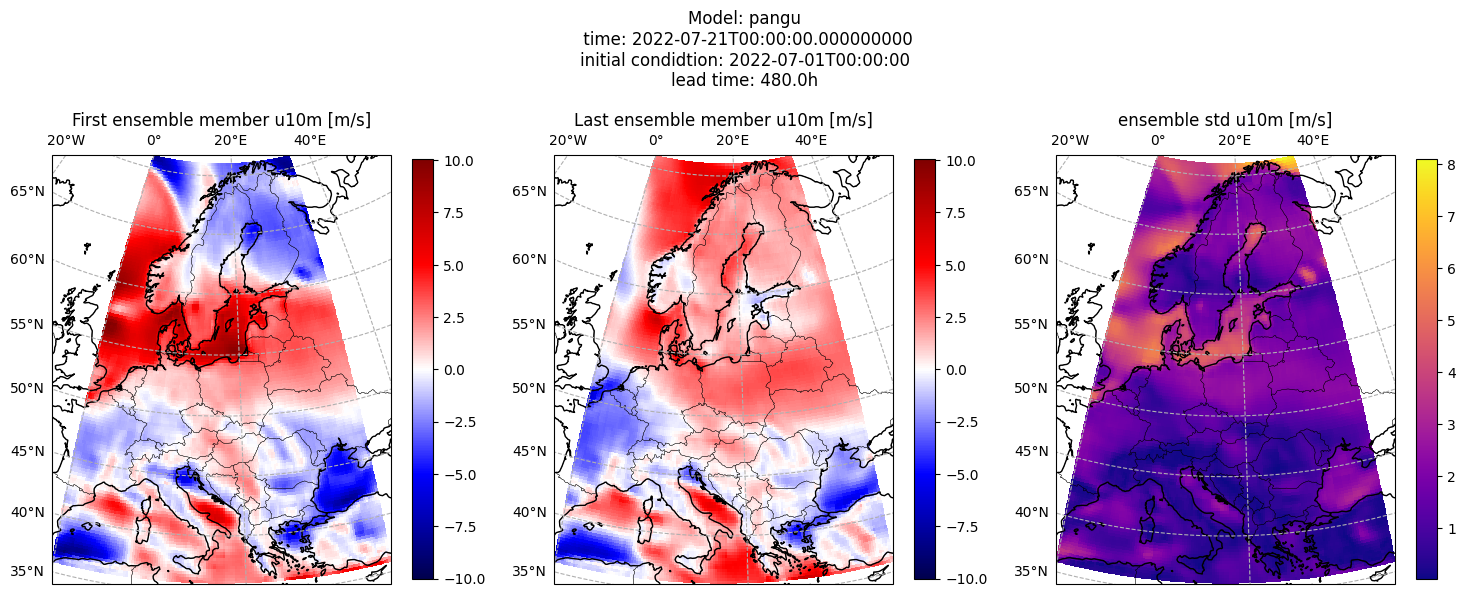

In [12]:
time_step = -1 # choose a time step, -1 for last

assert domain['type'] == 'Window', print('only for Window domain')
cen_lat = ds.lat.mean().item()
cen_lon = ds.lon.mean().item()

fig = plt.figure(figsize=(15, 6.5))
plt.rcParams['figure.dpi'] = 100
proj = ccrs.NearsidePerspective(central_longitude=cen_lon, central_latitude=cen_lat)
lead_time = np.array((pd.to_datetime(ds.time) - pd.to_datetime(ds.time)[0]).total_seconds()/3600)
fig.suptitle(f'Model: {config["weather_model"]}\n time: {str(ds.time[time_step].values)}\ninitial condidtion: {config["weather_event"]["properties"]["start_time"]}\nlead time: {lead_time[time_step]}h')

data = ds.u10m[0,time_step,:,:]
norm = mcolors.CenteredNorm(vcenter=0)
ax = fig.add_subplot(131, projection=proj)
ax.set_title('First ensemble member u10m [m/s]')
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic")
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.80, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.bottom_labels=False
gl.right_labels=False

data = ds.u10m[-1,time_step,:,:]
ax = fig.add_subplot(132, projection=proj)
plt.rcParams['figure.dpi'] = 100
proj = ccrs.NearsidePerspective(central_longitude=cen_lon, central_latitude=cen_lat)
ax.set_title('Last ensemble member u10m [m/s]')
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic")
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.80, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.bottom_labels=False
gl.right_labels=False

ds_ensemble_std = ds.std(dim = "ensemble")
data = ds_ensemble_std.u10m[-1,:,:]
proj = ccrs.NearsidePerspective(central_longitude=cen_lon, central_latitude=cen_lat)
ax = fig.add_subplot(133, projection=proj)
ax.set_title('ensemble std u10m [m/s]')
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), cmap="plasma")
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.80, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.bottom_labels=False
gl.right_labels=False

plt.tight_layout()

And that completes the introductory notebook into running ensemble weather predictions with AI. In the next notebook, we will look at running different models using more Pythonic APIs and plotting geopotential fields. 